In [1]:
import sys
print(sys.executable)
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
print("Imported libs")

/Users/anton/Projects/internet-measurements/.venv/bin/python
Imported libs


In [2]:
# Load data
df = pl.read_csv("lisbon.csv")
print(df.head())

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ timestamp ┆ balancerI ┆ balancerI ┆ clientIpA ┆ … ┆ latencyTC ┆ latencyTL ┆ latencyFi ┆ latencyD │
│ ---       ┆ d         ┆ p         ┆ ccordingC ┆   ┆ P         ┆ S         ┆ rstByte   ┆ ownload  │
│ f64       ┆ ---       ┆ ---       ┆ loudflare ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
│           ┆           ┆           ┆ str       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.7690e9  ┆ 107f211   ┆ 104.16.13 ┆ 185.32.19 ┆ … ┆ 3         ┆ 46        ┆ 15        ┆ 6        │
│           ┆           ┆ 3.229     ┆ 0.187     ┆   ┆           ┆           ┆           ┆          │
│ 1.7690e9  ┆ 107f156   ┆ 104.16.13 ┆ 185.32.19 ┆ … ┆ 1         ┆ 18        

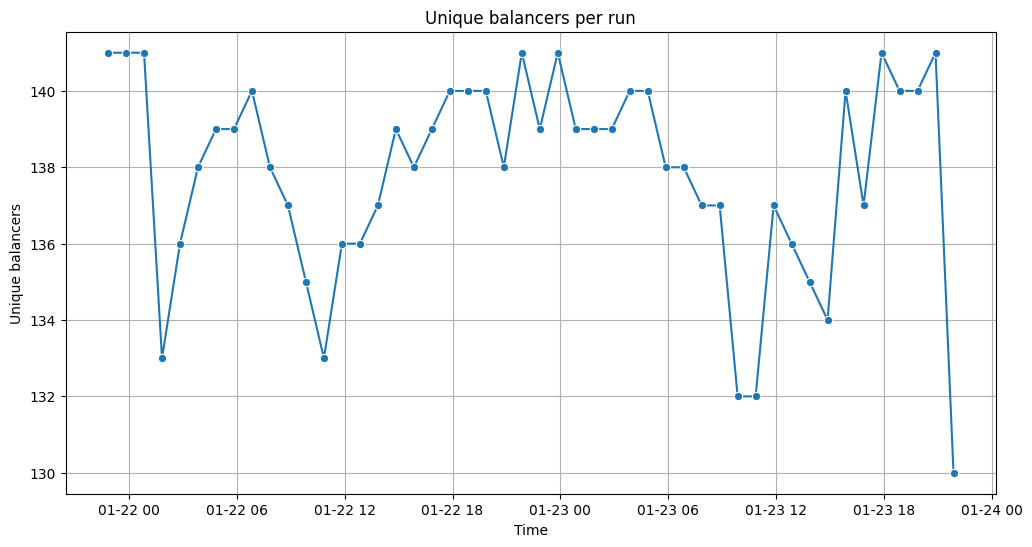

In [3]:
# Group by runs (gap > 20 mins)
stats = (
    df.sort("timestamp")
    .with_columns(
        # Identify gaps larger than 20 minutes (1200 seconds)
        # Use fill_null(0) to treat the first row as NO gap, keeping it in the first group
        (pl.col("timestamp").diff().fill_null(0) > (20 * 60)).cum_sum().alias("run_id")
    )
    .group_by("run_id")
    .agg([
        pl.col("timestamp").min().alias("start_time"),
        pl.col("balancerId").n_unique().alias("unique_balancers"),
        pl.len().alias("requests")
    ])
    .with_columns(
        # Convert unix timestamp to datetime
        pl.from_epoch(pl.col("start_time").cast(pl.Int64), time_unit="s").alias("start_time_dt")
    )
    .sort("start_time")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=stats, x="start_time_dt", y="unique_balancers", marker="o")
plt.title("Unique balancers per run")
plt.xlabel("Time")
plt.ylabel("Unique balancers")
plt.grid(True)
plt.show()

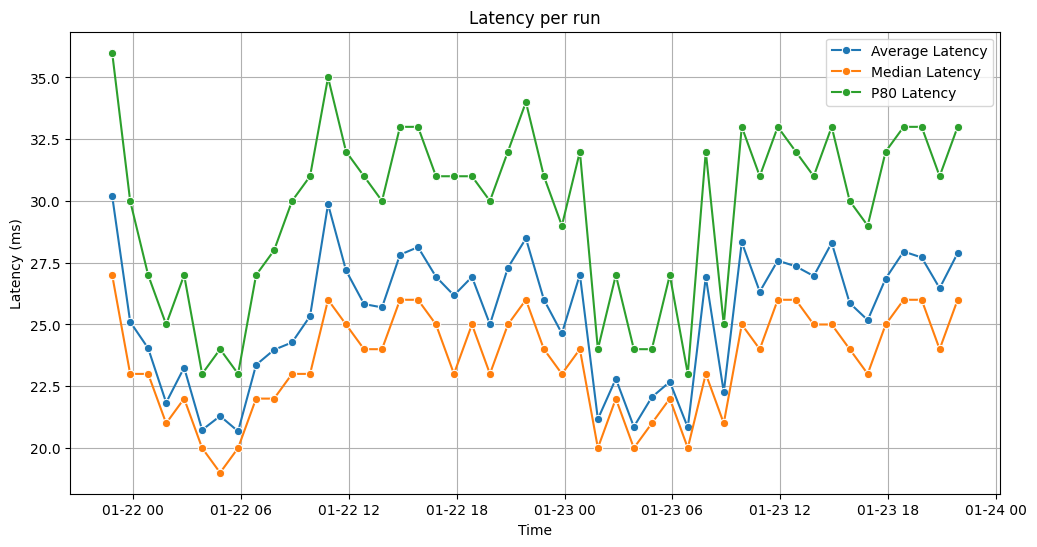

In [4]:
latency_stats = (
    df.sort("timestamp")
    .with_columns(
        (pl.col("timestamp").diff().fill_null(0) > (20 * 60)).cum_sum().alias("run_id")
    )
    .group_by("run_id")
    .agg([
        pl.col("timestamp").min().alias("start_time"),
        pl.col("latencyTotal").mean().alias("avg_latency"),
        pl.col("latencyTotal").median().alias("median_latency"),
        pl.col("latencyTotal").quantile(0.80).alias("p80_latency")
    ])
    .with_columns(
        pl.from_epoch(pl.col("start_time").cast(pl.Int64), time_unit="s").alias("start_time_dt")
    )
    .sort("start_time")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=latency_stats, x="start_time_dt", y="avg_latency", marker="o", label="Average Latency")
sns.lineplot(data=latency_stats, x="start_time_dt", y="median_latency", marker="o", label="Median Latency")
sns.lineplot(data=latency_stats, x="start_time_dt", y="p80_latency", marker="o", label="P80 Latency")
plt.title("Latency per run")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.legend()
plt.show()

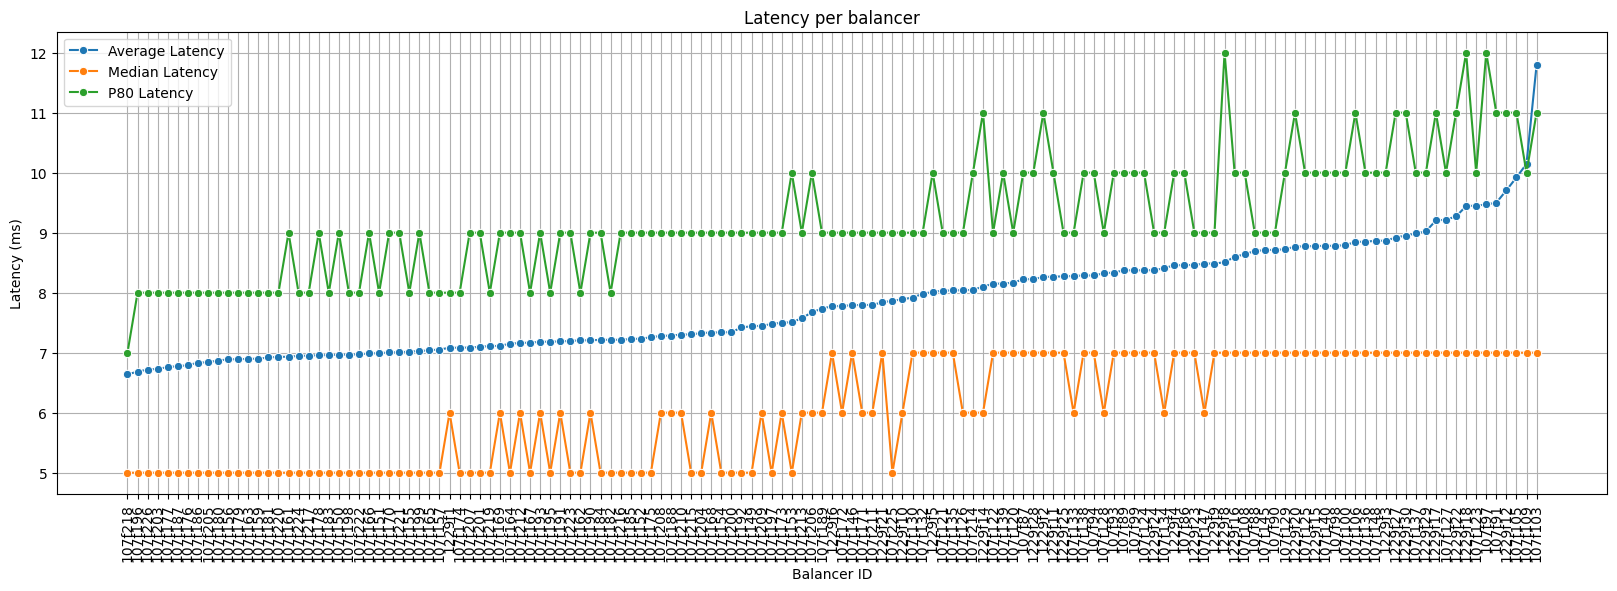

In [11]:
latency_stats_by_balancer = (
    df.group_by("balancerId")
    .agg([
        pl.col("latencyFirstByte").mean().alias("avg_latency"),
        pl.col("latencyFirstByte").median().alias("median_latency"),
        pl.col("latencyFirstByte").quantile(0.80).alias("p80_latency")
    ])
    .sort("avg_latency")
)

plt.figure(figsize=(20, 6))
sns.lineplot(data=latency_stats_by_balancer, x="balancerId", y="avg_latency", marker="o", label="Average Latency")
sns.lineplot(data=latency_stats_by_balancer, x="balancerId", y="median_latency", marker="o", label="Median Latency")
sns.lineplot(data=latency_stats_by_balancer, x="balancerId", y="p80_latency", marker="o", label="P80 Latency")
plt.title("Latency per balancer")
plt.xlabel("Balancer ID")
plt.ylabel("Latency (ms)")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

In [17]:
colocs = df.group_by("balancerColocationCenter").agg()
print(colocs.head())

shape: (1, 1)
┌──────────────────────────┐
│ balancerColocationCenter │
│ ---                      │
│ str                      │
╞══════════════════════════╡
│ LIS                      │
└──────────────────────────┘


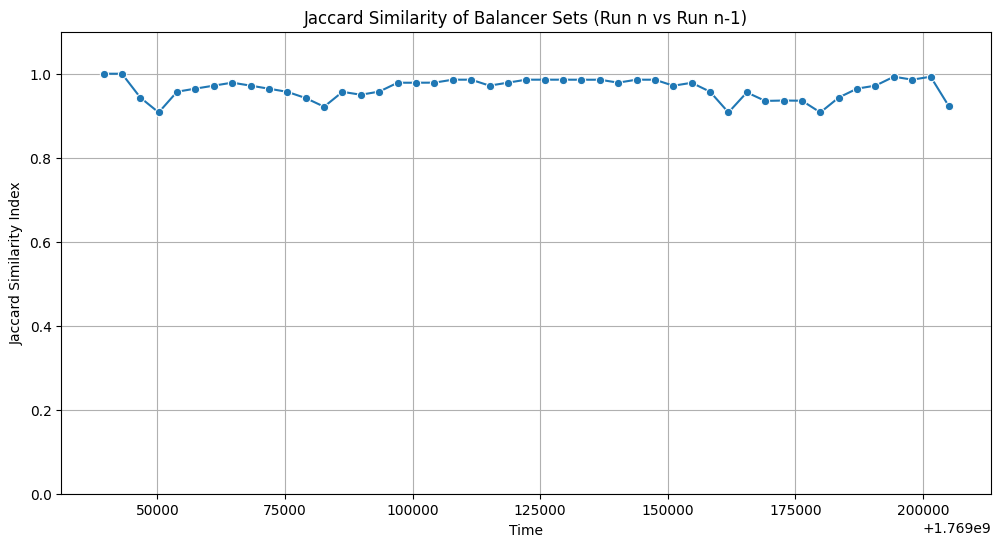

In [22]:
# Jaccard Similarity Analysis
# Re-calculating run_id to ensure we have it for this analysis
df_runs = df.sort("timestamp").with_columns(
    (pl.col("timestamp").diff().fill_null(0) > 1200).cum_sum().alias("run_id")
)

# Group by run_id and collect balancerIds
run_balancers = (
    df_runs.group_by("run_id")
    .agg([
        pl.col("timestamp").min().alias("start_time"),
        pl.col("balancerId").unique().alias("balancers")
    ])
    .sort("run_id")
)

# Calculate Jaccard Similarity between consecutive runs
jaccard_scores = []
run_ids = run_balancers["run_id"].to_list()
start_times = run_balancers["start_time"].to_list()
balancers_sets = [set(b) for b in run_balancers["balancers"].to_list()]

for i in range(len(run_ids) - 1):
    set_a = balancers_sets[i]
    set_b = balancers_sets[i+1]
    
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    jaccard = intersection / union if union > 0 else 0.0
    
    jaccard_scores.append({
        "run_id": run_ids[i+1],
        "start_time": start_times[i+1],
        "jaccard_similarity": jaccard
    })

df_jaccard = pl.DataFrame(jaccard_scores)

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_jaccard, x="start_time", y="jaccard_similarity", marker="o")
plt.title("Jaccard Similarity of Balancer Sets (Run n vs Run n-1)")
plt.xlabel("Time")
plt.ylabel("Jaccard Similarity Index")
plt.ylim(0, 1.1)
plt.grid(True)
plt.show()

In [ ]:
df_with_ts = df.with_columns(
    pl.from_epoch(pl.col("timestamp").cast(pl.Int64), time_unit="s").alias("timestamp_dt")
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_with_ts, x="timestamp_dt", y="latencyTotal", marker="o")
plt.title("Latency over time")
plt.xlabel("Time")
plt.ylabel("Latency")
plt.grid(True)
plt.show()

ValueError: Could not interpret value `totalLatency` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>